# Основная программа

Enter path to .xes / .csv file:  "C:\Users\Ilya\PycharmProjects\logskeletonProject\running-example.csv"
Your case_id column:  case:concept:name
Your activity_key column:  concept:name
Your timestamp column:  time:timestamp


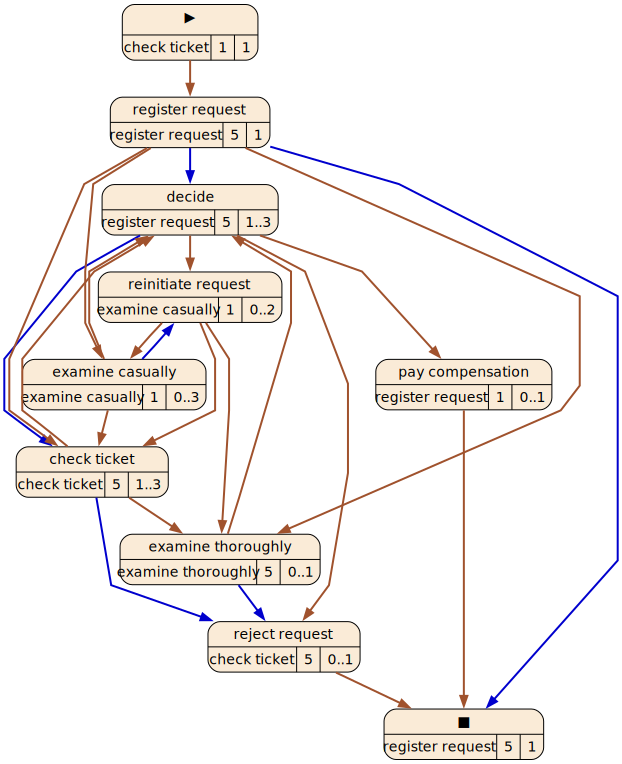

In [2]:
from typing import Any, Dict

from chardet import detect
from pandas import DataFrame, read_csv
from pm4py import (
    discover_log_skeleton,
    format_dataframe,
    read_xes,
)
from pm4py.analysis import insert_artificial_start_end

from visualize import visualize_model


def getting_log(file_path: str) -> DataFrame:
    if file_path.lower().endswith(".xes"):
        log_df = read_xes(file_path)

    elif file_path.lower().endswith(".csv"):
        with open(file_path, "rb") as f:
            result = detect(f.read())

        log_df = read_csv(file_path, encoding=result["encoding"])
        while True:
            case_id = input("Your case_id column: ")
            activity_key = input("Your activity_key column: ")
            timestamp_key = input("Your timestamp column: ")
            try:
                log_df = format_dataframe(
                    log_df,
                    case_id=case_id,
                    activity_key=activity_key,
                    timestamp_key=timestamp_key,
                    timest_format="%Y-%m-%d %H:%M:%S",
                )
                break
            except Exception:
                print("Your values is not in the dataframe!")
    else:
        raise ValueError("Supported extensions: .xes or .csv")

    log_df = insert_artificial_start_end(log_df)

    return log_df


def build_log_skeleton(log: DataFrame, noise: float = 0.9) -> Dict[str, Any]:
    return discover_log_skeleton(log, noise_threshold=noise)


def main() -> None:
    path = input("Enter path to .xes / .csv file: ").strip('"').strip()
    log = getting_log(path)

    log_skeleton = build_log_skeleton(log)
    # print(log_skeleton)    # Отладка

    visualize_model(log_skeleton)


if __name__ == "__main__":
    main()

# Модуль визуализации

In [ ]:
from graphviz import Digraph
from collections import defaultdict

# Часть программы, отвечающая за визуализацию лога событий в модели logskeleton
def find_pair(element, tuples): # Функция, которая находит второй элемент в паре
    for tuple_item in tuples:
        if tuple_item[0] == element:
            return tuple_item[1]
        elif tuple_item[1] == element:
            return tuple_item[0]
    return None
def find_first(element, tuples): # Функция, которая проверяет, стоит ли элемент в паре первым
    for t in tuples:
        if element == t[0]:
            return True


def find_max_in_tuples(dictionary, tuple_list): # Находит максимальное значение в парах (используется для специальных словарей)
    max_value = -float('inf')
    max_key = None

    for pair in tuple_list:
        for element in pair:
            if element in dictionary:
                if dictionary[element] > max_value:
                    max_value = dictionary[element]
                    max_key = element
    return max_value


def group_connected_tuples(tuple_list): # Функция, которая находит и составляет группы связанных элементов по эквивалентности (требует доработки)
    groups = defaultdict(list)
    element_to_group = {}
    group_counter = 0

    for tuple_item in tuple_list:
        a, b = tuple_item
        a_group = element_to_group.get(a)
        b_group = element_to_group.get(b)

        if a_group is None and b_group is None:
            current_group = group_counter
            group_counter += 1
            groups[current_group].append(tuple_item)
            element_to_group[a] = current_group
            element_to_group[b] = current_group
        elif a_group is not None and b_group is None:
            groups[a_group].append(tuple_item)
            element_to_group[b] = a_group
        elif b_group is not None and a_group is None:
            groups[b_group].append(tuple_item)
            element_to_group[a] = b_group
        elif a_group == b_group:
            groups[a_group].append(tuple_item)
        else:
            if len(groups[a_group]) < len(groups[b_group]):
                small_group, large_group = a_group, b_group
            else:
                small_group, large_group = b_group, a_group

            for item in groups[small_group]:
                groups[large_group].append(item)
                for element in item:
                    element_to_group[element] = large_group

            groups[large_group].append(tuple_item)
            element_to_group[a] = large_group
            element_to_group[b] = large_group

            del groups[small_group]

    result = {}
    element_to_value = {}

    for group in groups.values():
        key = str(group)
        value = len(group)
        result[key] = value
        for tuple_item in group:
            for element in tuple_item:
                element_to_value[element] = value

    return result, element_to_value
def visualize_model(model): # Основная функция визуализации
    always_after = model.get("always_after", [])
    always_before = model.get("always_before", [])
    directly_follows = model.get("directly_follows", [])
    equivalence = model.get("equivalence", [])
    never_together = model.get("never_together", [])
    activ_freq = model["activ_freq"].items()
    list_activ_freq = model.get("activ_freq", [])

    dot = Digraph("LogSkeleton", format="png", engine="dot")
    dot.attr(rankdir="TB", splines="polyline", bgcolor="white")
    dot.attr("node",
             shape="Mrecord",
             style="filled",
             fontname="Sans",
             fontsize="14")

    # - Строим диоды (рёбра, направленные в одну сторону)
    df = []
    for a, b in directly_follows:
        if (b,a) in df:
            continue
        df.append((a,b))
        dot.edge(a, b, color="sienna", penwidth="2")

    # - Исключаем повторяющиеся рёбра
    setdf = set(df)

    inp_a = []
    inp_b = []
    for a, b in always_after:
        if a == '▶' and (a,b) not in never_together and (b,a) not in never_together:
            inp_a.append((a,b))
            continue
        if b == '■' and (a,b) not in never_together and (b,a) not in never_together:
            inp_b.append((a,b))
            continue

    filtered_inp_a = [i for i in inp_a if i not in setdf]
    filtered_inp_b = [i for i in inp_b if i not in setdf]
    r = []

    # - Строим рёбра с отношением ответа (response)
    for a,b in always_after:
        if a == '▶':
            if b == '■':
                continue
            elif any(a in s for s in df) and (a, b) not in filtered_inp_a:
                continue
        if b == '■' and any(b in s for s in df) and (a, b) not in filtered_inp_b:
            continue
        if (b,a) in r:
            continue
        if (a,b) in equivalence and (a,b) not in directly_follows:
            r.append((a,b))
            dot.edge(a, b, color="#0000CD", penwidth="2")

    groups, counts = group_connected_tuples(r) # - Объединяем вершины в группы
    dict_counts = dict.fromkeys(list_activ_freq, 0) # - Создаем словарь с счетчиком того, сколько раз вершина встречалась в диодах
    for a, b in df:
        if a in dict_counts:
            dict_counts[a] += 1
        if b == '■' and b in dict_counts:
            dict_counts[b] += 1

    # - Строим вершины графа
    for act, cnt in activ_freq:
        if act not in counts:
            counts[act] = dict_counts[act]
        eq_elem = find_pair(act, r)
        if eq_elem == None:
            eq_elem = find_pair(act, equivalence)
        ord_elem = list(list_activ_freq.keys())
        if ((ord_elem.index(act) < ord_elem.index(eq_elem)) and act != '▶') or eq_elem == '▶':
            eq_elem = act

        lo, hi = min(cnt), max(cnt)
        if lo != hi:
            interval = f"{lo}..{hi}"
        elif lo == 0 and hi == 0:
            interval = f"{lo}..1"
        else:
            interval = str(hi)

        label = f"{{ {act} | {{ {eq_elem} | {counts[act]} | {interval} }} }}"
        dot.node(act, label=label, fillcolor='antiquewhite')

    # - Строим рёбра с отношением не существования (not co-existence)
    for a, b in never_together:
        if (find_first(a, r) and find_first(b, r)) and (a,b) not in equivalence and (b,a) not in equivalence:
            dot.edge(a, b, color="black", dir="both", arrowhead="tee", arrowtail="tee")
            break

    display(dot)